In [1]:
import numpy as np
from DiscretizeTools import NormalDiscrete1, NormalDiscrete2, grow_grid
from linear import LinintGrow, LinintEqui
from scipy.optimize import root, fsolve
import matplotlib.pyplot as plt
from ToolBox import SortOrder
from joblib import Parallel, delayed

In [2]:
class PortfolioChoiceRetAccounts:
    
    def __init__(self, 
                 JR = 45, J = 80, NW = 5, NS = 5, NR = 5, NA = 81, NX = 81, NAR = 81,
                 γ = 0.1, β = 0.96, σζ = 0.0738, σϵ = 0.0106, σχ = 0.157**2, ρ = 0, ξ = 0.07,
                 arl = 0, aru = 500, argrow = 0.07, ωj = 0.5, τ = 0.2,
                 rf = 0.02, μr = 0.04, al = 0, au = 250, agrow = 0.07, Xgrow = 0.05, κ = 0.5, w = 1,
                 ψ = np.array([1.00000, 0.99923, 0.99914, 0.99914, 0.99912, \
                0.99906, 0.99908, 0.99906, 0.99907, 0.99901, \
                0.99899, 0.99896, 0.99893, 0.99890, 0.99887, \
                0.99886, 0.99878, 0.99871, 0.99862, 0.99853, \
                0.99841, 0.99835, 0.99819, 0.99801, 0.99785, \
                0.99757, 0.99735, 0.99701, 0.99676, 0.99650, \
                0.99614, 0.99581, 0.99555, 0.99503, 0.99471, \
                0.99435, 0.99393, 0.99343, 0.99294, 0.99237, \
                0.99190, 0.99137, 0.99085, 0.99000, 0.98871, \
                0.98871, 0.98721, 0.98612, 0.98462, 0.98376, \
                0.98226, 0.98062, 0.97908, 0.97682, 0.97514, \
                0.97250, 0.96925, 0.96710, 0.96330, 0.95965, \
                0.95619, 0.95115, 0.94677, 0.93987, 0.93445, \
                0.92717, 0.91872, 0.91006, 0.90036, 0.88744, \
                0.87539, 0.85936, 0.84996, 0.82889, 0.81469, \
                0.79705, 0.78081, 0.76174, 0.74195, 0.72155, \
                0.00000]),
                 
                 eff = np.array([1.0000, 1.0719, 1.1438, 1.2158, 1.2842, 1.3527, \
                1.4212, 1.4897, 1.5582, 1.6267, 1.6952, 1.7217, \
                1.7438, 1.7748, 1.8014, 1.8279, 1.8545, 1.8810, \
                1.9075, 1.9341, 1.9606, 1.9623, 1.9640, 1.9658, \
                1.9675, 1.9692, 1.9709, 1.9726, 1.9743, 1.9760, \
                1.9777, 1.9700, 1.9623, 1.9546, 1.9469, 1.9392, \
                1.9315, 1.9238, 1.9161, 1.9084, 1.9007, 1.8354, \
                1.7701, 1.7048])):
        
        self.JR , self.J  , self.NW, self.NS, self.NR, self.NA, self.NX, self.NAR = JR, J, NW, NS, NR, NA, NX, NAR
        self.γ  , self.β  , self.σζ, self.σϵ, self.σχ, self.ρ , self.ξ , self.τ  = γ , β, σζ, σϵ, σχ, ρ , ξ, τ
        self.arl, self.aru, self.argrow = arl, aru, argrow,
        self.rf, self.μr, self.al, self.au, self.agrow, self.Xgrow, self.κ, self.w = rf, μr, al, au, agrow, Xgrow, κ, w 
        self.NSR  = NS*NR
        self.egam = 1- 1/γ
        
         # surving probability and labor efficiency and pensions
        self.ψ   = ψ
        self.eff = np.concatenate((eff, np.zeros(J - JR +1)))
        self.pen = np.concatenate((np.zeros(JR - 1), np.ones(J - JR + 1)*(κ*w*eff[-1])))
        
        # discretize zeta shocks
        ζ, self.πζ = NormalDiscrete1(NW,0,σζ)
        self.ζ     = np.exp(ζ)
        
        # discretize eps-ctheta shocks
        temp, self.πsr = NormalDiscrete2(n = [NS, NR], sigma = [σϵ, σχ], rho = ρ)
        self.eps       = np.exp(temp[:,0])
        self.χ         = temp[:,1]
        
        # asset grid
        self.a  = grow_grid(al, au, agrow, NA)
        self.ar = grow_grid(arl, aru, argrow, NAR)
        
        # calculate the price of an annuity
        self.pa = 0
        ψcum = 1
        for j in range(JR-1, J):
            ψcum = ψcum*ψ[j]
            self.pa += ψcum/(1+rf)**(j-JR + 2)
        self.pa = (1 + ξ)*self.pa
        
        if len(np.array([ωj])) == 1:
            self.ωj = np.concatenate((np.full(JR - 1, ωj), np.zeros(J - JR + 1)))
        else:
            self.ωj = np.concatenate((np.array(ωj) , np.zeros(J - JR + 1)))
        
        
        # endogenous lower and upper bound of cash-on-hand grid
        self.Xl = min((1-τ)*w*np.amin(eff[:JR-1])*np.amin(self.eps)*self.ζ[0], self.pen[JR-1])
        self.Xu = (1 + (1-τ)*(rf + μr + np.amax(self.χ)))*au + \
                max((1-τ)*w*np.amax(eff[:JR-1])*np.amax(self.eps)*ζ[-1], aru/self.pa)
        self.X  = grow_grid(self.Xl, self.Xu, Xgrow, NX)
        
        
        self.aplus, self.c, self.V, self.Ω, self.Var, self.Ωr = self.policy()

        
    def policy(self):
        global S, Sar, RHS, Q, Qar, Qal
        S   = np.zeros((self.J, self.NA, self.NAR))
        Sar = np.zeros((self.J, self.NA, self.NAR))
        RHS = np.zeros((self.J, self.NA, self.NAR))
        Q   = np.zeros((self.J, self.NA, self.NAR))
        Qar = Q.copy()
        Qal = Q.copy()
        
        margu = lambda x: max(x, 1e-10)**(-1/self.γ)

        
        def valuefunc(aplus, cons, j, iir):

            caux = max(cons, 1e-10)
            il, ir, φ = LinintGrow(aplus, self.al, self.au, self.agrow, self.NA)

            VF = 0
            if j < self.J - 1:
                VF = max( φ   * S[j, il, iir] + \
                         (1-φ)* S[j, ir, iir] , 1e-10)**self.egam/self.egam

            VF = caux**self.egam/self.egam + self.β*self.ψ[j+1]*VF

            return VF
        
        def SolveRetaccount(j, i, irr):
            
            def FocRet(p):
                alp = (1-p)*self.a[i]
                arp = self.ar[irr] + p*self.a[i]/(1-self.τ)
                
                ial, iar, φa = LinintGrow(alp, self.al, self.au, self.agrow, self.NA)
                rl, rr, φr   = LinintGrow(arp, self.arl, self.aru, self.argrow, self.NAR)
                
                if φa <= φr:
                    Qall = φa       * Qal[j, ial, rl] + \
                          (φr - φa) * Qal[j, iar, rl] + \
                          ( 1 - φr) * Qal[j, iar, rr]
                    Qarr = φa       * Qar[j, ial, rl] + \
                          (φr - φa) * Qar[j, iar, rl] + \
                          ( 1 - φr) * Qar[j, iar, rr]
                else:
                    Qall = φr       * Qal[j, ial, rl] + \
                          (φa - φr) * Qal[j, ial, rr] + \
                          ( 1 - φa) * Qal[j, iar, rr]
                    Qarr = φr       * Qar[j, ial, rl] + \
                          (φa - φr) * Qar[j, ial, rr] + \
                          ( 1 - φa) * Qar[j, iar, rr]

                Qall = max(Qall, 1e-10)**(-1/self.γ)
                Qarr = max(Qarr, 1e-10)**(-1/self.γ)
                
                return Qall/(Qarr/(1-self.τ)) - 1
            
            ret0 = FocRet(0)
            ret1 = FocRet(1)
            
            if ret0*ret1 > 0:
                if abs(ret0) > abs(ret1) :
                    Ωraux = 1
                else:
                    Ωraux = 0
            else:
                if i > 1:
                    guess = Ωr[j, i-1,irr]
                else:
                    guess = -ret0/(ret1-ret0)
                    
                res = root(FocRet, x0 = guess)
                if res.x[0] < 0 or res.x[0] >1:
                    xl = 0
                    xr = 1
                    fl = ret0

                    for it in range(1000):
                        xnew = (xl + xr)/2
                        fnew = FocRet(xnew)

                        if abs(xnew-xl) < 1e-8:
                            Ωraux = xnew
                            break
                        if it == 999:
                            Ωraux = xnew
                            break

                        if fl*fnew <= 0:
                            xr = xnew
                        else:
                            xl = xnew
                            fl = fnew
                else:
                    Ωraux = res.x[0]
            return Ωraux



        
        
        def SolvePortfolio(j, i, irr):
                
            def FocPort(p):
                foc_port = 0
                if j + 1 >= self.JR - 1:
                    for sr in range(self.NSR):
                        Rport = 1 + (1-self.τ)*(self.rf + p*(self.μr + self.χ[sr]))
                        Xp = Rport*self.a[i] + self.pen[j + 1] + (1-self.τ)*self.ar[irr]/self.pa
                        ixl, ixr, φ = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                        dist = self.πsr[sr]
                        cp = max(φ * c[j+1, ixl, irr] + (1-φ)* c[j+1, ixr, irr], 1e-10)
                        foc_port += dist*(1-self.τ)*(self.μr + self.χ[sr]) * self.a[i] * margu(cp)
                else:
                    for iw in range(self.NW):
                        for sr in range(self.NSR):
                            Rport = 1 + (1-self.τ)*(self.rf + p*(self.μr + self.χ[sr]))
                            earnings = (1-self.τ)*self.w * self.eff[j+1]*self.ζ[iw]
                            Xp = Rport*self.a[i]/self.eps[sr] + earnings
                            ixl, ixr, φX = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                            Rj = 1 + self.rf + self.ωj[j+1]*(self.μr + self.χ[sr])
                            arp = Rj *self.ar[irr]/self.eps[sr]
                            
                            rl, rr, φr = LinintGrow(arp, self.arl, self.aru, self.argrow, self.NAR)
                            
                            dist = self.πζ[iw] * self.πsr[sr]
                            if φX <= φr:
                                cp = max( φX     * c[j+1, ixl, rl] + \
                                         (φr-φX) * c[j+1, ixr, rl] + \
                                         (1 -φr) * c[j+1, ixr, rr], 1e-10)
                            else:
                                cp = max( φr     * c[j+1, ixl, rl] + \
                                         (φX-φr) * c[j+1, ixl, rr] + \
                                         (1 -φX) * c[j+1, ixr, rr], 1e-10)
                            foc_port += dist*(1-self.τ)*(self.μr + self.χ[sr])*self.a[i] * margu(self.eps[sr]*cp)
                return foc_port
            
            port0 = FocPort(0)
            port1 = FocPort(1)
            
            if port0*port1 > 0:
                if abs(port0) > abs(port1):
                    Ωaux = 1
                else:
                    Ωaux = 0
            else:
                tol = 1e-5*abs(port0-port1)
                tol = min(tol, 1e-8)
                if i > 1:
                    guess = Ω[j, i -1 , irr]
                else:
                    guess = -port0/(port1 - port0)
                
                res = root(FocPort, x0 = guess, tol = tol)
                
                if res.x[0] < 0 or res.x[0] >1:
                    xl = 0
                    xr = 1
                    fl = port0
                    
                    for it in range(1000):
                        xnew = (xl + xr)/2
                        fnew = FocPort(xnew)
                        
                        if abs(xnew-xl) < 1e-8:
                            Ωaux = xnew
                            break
                        if it == 999:
                            Ωaux = xnew
                            break
                        
                        if fl*fnew <= 0:
                            xr = xnew
                        else:
                            xl = xnew
                            fl = fnew
                else:
                    Ωaux = res.x[0]
            return Ωaux
        
        def SolveConsum(j, ix, irr):
            
            def dVar(ap, jj, rr):
                ial, iar, φ = LinintGrow(ap, self.al, self.au, self.agrow, self.NA)

                dVar = φ*Sar[jj, ial, rr] + (1-φ)*Sar[jj, iar, rr]
                dVar = (self.β*self.ψ[jj+1])**(-self.γ)*dVar
                return dVar
            
            def FocCons(app):
                cons_com = self.X[ix] - app
                ial, iar, φ = LinintGrow(app, self.al, self.au, self.agrow, self.NA)
                tomorrow = φ * RHS[j, ial, irr] + (1-φ) * RHS[j, iar, irr]
                foc = cons_com - tomorrow
                return foc

            
            if self.X[ix] < 1e-10:
                aaux = 0
                caux = 0
                Vaux = valuefunc(0,0,j,irr)
                Varaux = dVar(0,j,irr)
                
            res = root(FocCons, x0 = aplus[j+1, ix, irr])
            
            if res.x[0] < 0:
                aaux = 0
                caux = self.X[ix]
            else:
                aaux = res.x[0]
                caux = self.X[ix] - aaux
            
            Vaux =  valuefunc(aaux, caux, j, irr)
            Varaux = dVar(aaux, j, irr)
            return Varaux, aaux, caux, Vaux
           
        
        def interpolate(j):
            global Q, Qar, Qal
            Q[j,:,:]   = 0
            Qar[j,:,:]   = 0
            Qal[j,:,:]   = 0
            
            for i in range(self.NA):
                for irr in range(self.NAR):
                    if j >= self.JR - 2:
                        for sr in range(self.NSR):
                            Rport        = 1 + (1-self.τ)*(self.rf + Ω[j,i,irr]*(self.μr + self.χ[sr]))      
                            Xp           = Rport * self.a[i] + self.pen[j+1] + (1-self.τ)*self.ar[irr]/self.pa
                            ixl, ixr, φ  = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                            
                            dist = self.πsr[sr]
                            cp           = max(φ*c[j+1,ixl,irr] + (1-φ)*c[j+1, ixr, irr], 1e-10)
                            
                            if j < self.J-2:
                                Varp = max( φ    * Var[j+1, ixl, irr] + \
                                           (1-φ) * Var[j+1, ixr, irr] , 1e-10)**(-1/self.γ)
                            else:
                                Varp = 0
                            
                            EV       = φ       * (self.egam*V[j + 1, ixl, irr])**(1/self.egam) + \
                                      (1 - φ)  * (self.egam*V[j + 1, ixr, irr])**(1/self.egam)
                            Qal[j, i, irr] += dist*Rport*margu(cp)
                            Qar[j, i, irr] += dist*((1-self.τ)*margu(cp)/self.pa + Varp)
                            Q[j, i, irr]   += dist*EV**self.egam/self.egam
                            
                    else:
                        for sr in range(self.NSR):
                            for iw in range(self.NW):
                                Rport = 1 + (1-self.τ)*(self.rf + Ω[j, i, irr]*(self.μr + self.χ[sr]))
                                Xp    = Rport * self.a[i]/self.eps[sr] + (1-self.τ)*self.w*self.eff[j+1]*self.ζ[iw]
                                ixl, ixr, φX = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)

                                Rj = 1 + self.rf + self.ωj[j + 1]*(self.μr + self.χ[sr])
                                arplus = Rj * self.ar[irr]/self.eps[sr]
                                rl, rr, φr = LinintGrow(arplus, self.arl, self.aru, self.argrow, self.NAR)

                                dist = self.πζ[iw]*self.πsr[sr]

                                if φX <= φr:
                                    cp   = φX       * c[j+1, ixl, rl] + \
                                          (φr - φX) * c[j+1, ixr, rl] + \
                                          ( 1 - φr) * c[j+1, ixr, rr]

                                    Varp = φX       * Var[j+1, ixl, rl] + \
                                          (φr - φX) * Var[j+1, ixr, rl] + \
                                          ( 1 - φr) * Var[j+1, ixr, rr]

                                    EV   = φX       * (self.egam*V[j+1, ixl, rl])**(1/self.egam) + \
                                          (φr - φX) * (self.egam*V[j+1, ixr, rl])**(1/self.egam) + \
                                          ( 1 - φr) * (self.egam*V[j+1, ixr, rr])**(1/self.egam)


                                else:
                                    cp   = φr       * c[j+1, ixl, rl] + \
                                          (φX - φr) * c[j+1, ixl, rr] + \
                                          ( 1 - φX) * c[j+1, ixr, rr]

                                    Varp = φr       * Var[j+1, ixl, rl] + \
                                          (φX - φr) * Var[j+1, ixl, rr] + \
                                          ( 1 - φX) * Var[j+1, ixr, rr]

                                    EV   = φr       * (self.egam*V[j+1, ixl, rl])**(1/self.egam) + \
                                          (φX - φr) * (self.egam*V[j+1, ixl, rr])**(1/self.egam) + \
                                          ( 1 - φX) * (self.egam*V[j+1, ixr, rr])**(1/self.egam)
                                cp = max(cp, 1e-10)
                                Varp = max(Varp, 1e-10)**(-1/self.γ)

                                Qal[j, i, irr] += dist*Rport*margu(self.eps[sr]*cp)
                                Qar[j, i, irr] += dist*Rj*self.eps[sr]**(-1/self.γ)*Varp
                                Q[j, i, irr]   += dist*(self.eps[sr]*EV)**self.egam/self.egam

                    Qal[j, i, irr] = Qal[j, i, irr]**(-self.γ)
                    Qar[j, i, irr] = Qar[j, i, irr]**(-self.γ)
                    Q[j, i, irr]   = (self.egam*Q[j, i, irr])**(1/self.egam)
            
        def interpolateRHS(j):
            global RHS, Sar, S
            
            if j  >= self.JR -1:
                RHS[j,:,:] = (self.β*self.ψ[j+1])**(-self.γ)*Qal[j,:,:]
                Sar[j,:,:] = Qar[j,:,:]
                S[j,:,:]   = Q[j,:,:]
                
            else:
                
                for i in range(self.NA):
                    for irr in range(self.NAR):
                        
                        alp = (1 - Ωr[j, i, irr]) * self.a[i]
                        arp = self.ar[irr] + Ωr[j, i, irr]* self.a[i] /(1-self.τ)
                        
                        ial, iar, φA = LinintGrow(alp, self.al, self.au, self.agrow, self.NA)
                        rl, rr, φr = LinintGrow(arp, self.arl, self.aru, self.argrow, self.NAR)
                        
                        if φA <= φr :
                            Qalp          = φA       * Qal[j, ial, rl] + \
                                           (φr - φA) * Qal[j, iar, rl] +\
                                           (1  - φr) * Qal[j, iar, rr]
                            
                            Qarp          = φA       * Qar[j, ial, rl] + \
                                           (φr - φA) * Qar[j, iar, rl] +\
                                           (1  - φr) * Qar[j, iar, rr]
                            S[j, i, irr]  = φA       * Q[j, ial, rl] + \
                                           (φr - φA) * Q[j, iar, rl] +\
                                           (1  - φr) * Q[j, iar, rr]
                        else:
                            Qalp          = φr       * Qal[j, ial, rl] + \
                                           (φA - φr) * Qal[j, ial, rr] +\
                                           (1  - φA) * Qal[j, iar, rr]
                            
                            Qarp          = φr       * Qar[j, ial, rl] + \
                                           (φA - φr) * Qar[j, ial, rr] +\
                                           (1  - φA) * Qar[j, iar, rr]
                            S[j, i, irr]  = φr       * Q[j, ial, rl] + \
                                           (φA - φr) * Q[j, ial, rr] +\
                                           (1  - φA) * Q[j, iar, rr]
                        
                        Qalp = max(Qalp, 1e-10)**(-1/self.γ)
                        Qarp = max(Qarp, 1e-10)**(-1/self.γ)
                        
                        RHS[j, i, irr] = (1 - Ωr[j,i,irr])*Qalp + Ωr[j,i,irr]*Qarp/(1-self.τ)
                        RHS[j, i, irr] = (self.β*self.ψ[j+1]*RHS[j, i, irr])**(-self.γ)
                        
                        Sar[j,i,irr] = Qarp**(-self.γ)
            
            
            

        Ω     = np.zeros((self.J, self.NA, self.NAR))
        V     = np.zeros((self.J, self.NX, self.NAR))
        Var   = np.zeros((self.J, self.NX, self.NAR))
        c     = np.zeros((self.J, self.NX, self.NAR))
        aplus = np.zeros((self.J, self.NX, self.NAR))
        Ωr    = np.zeros((self.J, self.NA, self.NAR))

        for ix in range(self.NX):
            aplus[-1,ix,:] = 0
            c[-1,ix,:]     = self.X[ix]
            V[-1,ix,:]     = valuefunc(0, c[-1,ix,0], self.J-1, 0)
        
        def ParaPort(i, age):
            Ωaux = np.zeros(self.NAR)
            j = age
            for irr in range(self.NAR):
                Ωaux[irr] = SolvePortfolio(j, i, irr)
            return Ωaux
        
        def ParaCon(ix,age):
            Vaaux = np.zeros(self.NAR)
            Vaux = np.zeros(self.NAR)
            aaux = np.zeros(self.NAR)
            caux = np.zeros(self.NAR)
            j = age
            
            for irr in range(self.NAR):
                Vaaux[irr], aaux[irr], caux[irr], Vaux[irr] = SolveConsum(j, ix, irr)
            return Vaaux, aaux, caux, Vaux
        
        for j in range(self.J-2, self.JR-2, -1):
            if j%5 ==0:
                print('Age {} - {} Done'.format(j+1, j+5))
            results = Parallel(n_jobs=18)(delayed(ParaPort)(i, age = j) for i in range(1, self.NA))
            for i in range(1, self.NA):
                    Ω[j,i,:] = results[i-1]
            Ω[j,0,:] = Ω[j,1,:]

            interpolate(j)
            interpolateRHS(j)
            
            results = Parallel(n_jobs=18)(delayed(ParaCon)(ix, age = j) for ix in range(self.NX))
            for ix in range(self.NX):
                Var[j,ix,:] = results[ix][0]
                aplus[j,ix,:] = results[ix][1]
                c[j,ix,:] = results[ix][2]
                V[j,ix,:] = results[ix][3]

        for j in range(self.JR-2, -1, -1):
            if j%5 ==0:
                print('Age {} - {} Done'.format(j+1, j+5))
            results = Parallel(n_jobs=18)(delayed(ParaPort)(i, age = j) for i in range(1, self.NA))
            for i in range(1, self.NA):
                Ω[j,i,:] = results[i-1]
            Ω[j,0,:] = Ω[j,1,:]
            interpolate(j)
            
            for i in range(1, self.NA):
                for irr in range(self.NAR):
                    Ωr[j,i,irr] = SolveRetaccount(j,i,irr)
            Ωr[j,0,:] = Ωr[j,1,:]
            
            interpolateRHS(j)
            
            results = Parallel(n_jobs=18)(delayed(ParaCon)(ix, age = j) for ix in range(self.NX))
            for ix in range(self.NX):
                Var[j,ix,:] = results[ix][0]
                aplus[j,ix,:] = results[ix][1]
                c[j,ix,:] = results[ix][2]
                V[j,ix,:] = results[ix][3]
            
        return aplus, c, V, Ω, Var, Ωr
        
        
        

In [3]:
def distribution(self):
    global ΦX, ΦA, Φr

    def distributionX(jj):
        global ΦX
        if jj == 0:
            for iw in range(self.NW):
                Xp = (1-self.τ)*self.w*self.eff[0]*self.ζ[iw]

                ixl, ixr, φ = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)

                dist = self.πζ[iw]

                ΦX[0, ixl, 0] += dist*φ
                ΦX[0, ixr, 0] += dist*(1-φ)

        if jj <= self.JR - 2:
            for i in range(self.NA):
                for ir in range(self.NAR):
                    for iw in range(self.NW):
                        for sr in range(self.NSR):
                            Rport = 1 + (1-self.τ)*(self.rf + self.Ω[jj-1, i, ir]*(self.μr + self.χ[sr]))
                            Xp    = Rport*self.a[i]/self.eps[sr] + (1-self.τ)*self.w*self.eff[jj]*self.ζ[iw]

                            ixl, ixr, φX = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)

                            Rj = 1 + self.rf + self.ωj[jj]*(self.μr + self.χ[sr])
                            arplus = Rj * self.ar[ir]/self.eps[sr]
                            rl, rr, φr1 = LinintGrow(arplus, self.arl, self.aru, self.argrow, self.NAR)
                            
                            dist = self.πζ[iw]*self.πsr[sr]
                            ΦX[jj,ixl,rl] += dist * φX *φr1 *Φr[jj-1,i, ir]
                            ΦX[jj,ixr,rl] += dist * (1-φX) *φr1 *Φr[jj-1,i, ir]
                            ΦX[jj,ixl,rr] += dist * φX * (1-φr1) *Φr[jj-1,i, ir]
                            ΦX[jj,ixr,rr] += dist * (1-φX) *(1-φr1) *Φr[jj-1,i, ir]
        else:

            for i in range(self.NA):
                for ir in range(self.NAR):
                    for sr in range(self.NSR):
                        Rport = 1 + (1-self.τ)*(self.rf + self.Ω[jj-1, i, ir]*(self.μr + self.χ[sr]))
                        Xp    = Rport*self.a[i] + self.pen[jj] + (1-self.τ)*self.ar[ir]/self.pa

                        ixl, ixr, φ = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)

                        ΦX[jj,ixl,ir] += self.πsr[sr] * φ   * Φr[jj-1, i, ir]
                        ΦX[jj,ixr,ir] += self.πsr[sr] *(1-φ)* Φr[jj-1, i, ir]

    
    def distributionA(jj):
        global ΦA
        for x in range(self.NX):
            for ir in range(self.NAR):
                ial, iar, φ = LinintGrow(self.aplus[jj, x, ir], self.al, self.au, self.agrow, self.NA)
                ial = min(ial, self.NA)
                iar = min(iar, self.NA)
                φ   = min(φ, 1)
                ΦA[jj, ial, ir] +=  φ    * ΦX[jj, x, ir]
                ΦA[jj, iar, ir] += (1-φ) * ΦX[jj, x, ir]
    
    def distributionR(jj):
        global Φr
        
        if jj >= self.JR - 1:
            Φr[j,:,:] = ΦA[j,:,:]
            
        else:
            for i in range(self.NA):
                for ir in range(self.NAR):
                    alp = (1-self.Ωr[j,i,ir])*self.a[i]
                    arp = self.ar[ir] + self.Ωr[j,i,ir]*self.a[i]/(1-self.τ)

                    ial, iar, φa = LinintGrow(alp, self.al, self.au, self.agrow, self.NA)
                    rl, rr, φr   = LinintGrow(arp, self.arl, self.aru, self.argrow, self.NAR)
                    
                    Φr[j, ial, rl] += φa * φr * ΦA[j,i,ir]
                    Φr[j, iar, rl] += (1-φa) * φr * ΦA[j,i,ir]
                    Φr[j, ial, rr] += φa * (1-φr) * ΦA[j,i,ir]
                    Φr[j, iar, rr] += (1-φa) * (1-φr) * ΦA[j,i,ir]
                    
                    
    ΦX = np.zeros((self.J, self.NX, self.NAR))
    ΦA = ΦX.copy()
    Φr = ΦX.copy()
    
    for j in range(self.J):
        if j%5 == 0:
                print('Age {} - {} Done'.format(j+1, j+5))
        distributionX(j)
        distributionA(j)
        distributionR(j)
        
    self.ΦX, self.ΦA, self.Φr = ΦX, ΦA, Φr
        

In [4]:
def aggregation(self):

    c_coh  = np.zeros(self.J)
    y_coh  = np.zeros(self.J)
    yp_coh = np.zeros(self.J)
    a_coh  = np.zeros(self.J)
    ar_coh = np.zeros(self.J)
    o_coh  = np.zeros(self.J)
    ΦX = self.ΦX
    ΦA = self.ΦA
    Φr = self.Φr

    for j in range(self.J):
        for iw in range(self.NW):
            y_coh[j] += (self.w*self.eff[j]*self.ζ[iw] + self.pen[j]) * self.πζ[iw]
        
        for ir in range(self.NAR):
            for x in range(self.NX):
                c_coh[j] += self.c[j, x, ir]*self.ΦX[j,x,ir]
                if j >= self.JR - 1:
                    yp_coh[j] += self.ar[ir]/self.pa *ΦX[j,x,ir]

            if j > 0:
                for i in range(self.NA):
                    a_coh[j]  += self.a[i]        * Φr[j-1,i,ir]
                    ar_coh[j] += self.ar[ir]      * Φr[j-1,i,ir]
                    o_coh[j]  += self.Ω[j-1, i,ir]* Φr[j-1,i,ir]


    var_c  = np.zeros(self.J)
    var_y  = np.zeros(self.J)
    var_yp = np.zeros(self.J)
    var_a  = np.zeros(self.J)
    var_ar = np.zeros(self.J)
    var_o  = np.zeros(self.J)

    for j in range(self.J):
        for iw in range(self.NW):
            var_y[j] += (self.w * self.eff[j]* self.ζ[iw] + self.pen[j])**2*self.πζ[iw]
        
        for ir in range(self.NAR):
            for x in range(self.NX):
                var_c[j] += self.c[j,x,ir]**2*ΦX[j,x,ir]
                if j >= self.JR -1:
                    var_yp[j] += (self.ar[ir]/self.pa)**2*ΦX[j,x,ir]
                    
            if j > 0:
                for i in range(self.NA):
                    var_a[j] += self.a[i]**2         * Φr[j-1, i, ir]
                    var_ar[j]+= self.ar[ir]**2       * Φr[j-1, i, ir]
                    var_o[j] += self.Ω[j-1, i,ir]**2 * Φr[j-1, i, ir]


    var_c  += -c_coh**2
    var_y  += -y_coh**2
    var_yp += -yp_coh**2
    var_a  += -a_coh**2
    var_ar += -ar_coh**2
    var_o  += -o_coh**2


    ση = self.σϵ*np.array([min(j, self.JR-2) for j in range(self.J)])

    μexp = np.exp(0.5*ση)
    σexp = np.exp(ση)*(np.exp(ση) - 1)

    var_y = μexp ** 2 * var_y + σexp*y_coh**2 + σexp*var_y
    var_c = μexp ** 2 * var_c + σexp*c_coh**2 + σexp*var_c
    var_yp = μexp ** 2 * var_yp + σexp*yp_coh**2 + σexp*var_yp
    var_a = μexp ** 2 * var_a + σexp*a_coh**2 + σexp*var_a
    var_ar = μexp ** 2 * var_ar + σexp*ar_coh**2 + σexp*var_ar

    y_coh = μexp*y_coh
    yp_coh = μexp*yp_coh
    c_coh = μexp*c_coh
    a_coh = μexp*a_coh
    ar_coh = μexp*ar_coh

    cv_y = np.zeros(self.J)
    cv_c = np.zeros(self.J)
    cv_a = np.zeros(self.J)
    cv_o = np.zeros(self.J)
    cv_yp = np.zeros(self.J)

    cv_y = np.maximum(var_y, 0)**0.5/np.maximum(y_coh, 1e-10)
    cv_c = np.maximum(var_c, 0)**0.5/np.maximum(c_coh, 1e-10)
    cv_a = np.maximum(var_a, 0)**0.5/np.maximum(a_coh, 1e-10)
    cv_o = np.maximum(var_o, 0)**0.5/np.maximum(o_coh, 1e-10)
    cv_yp = np.maximum(var_yp, 0)**0.5/np.maximum(yp_coh, 1e-10)

    self.c_coh, self.y_coh, self.a_coh, self.o_coh, self.yp_coh, self.ar_coh,\
    self.cv_c, self.cv_y, self.cv_a, self.cv_o, self.cv_yp = \
    c_coh, y_coh, a_coh, o_coh, yp_coh, ar_coh, cv_c, cv_y, cv_a, cv_o, cv_yp


In [5]:
%%time
model2 = PortfolioChoiceRetAccounts(ωj = 0.5)
distribution(model2)
aggregation(model2)

Age 76 - 80 Done
Age 71 - 75 Done
Age 66 - 70 Done


KeyboardInterrupt: 

In [7]:
%%time
model3 = PortfolioChoiceRetAccounts(ωj = 0.1)
distribution(model3)
aggregation(model3)

Age 76 - 80 Done
Age 71 - 75 Done
Age 66 - 70 Done
Age 61 - 65 Done
Age 56 - 60 Done
Age 51 - 55 Done
Age 46 - 50 Done
Age 41 - 45 Done
Age 36 - 40 Done
Age 31 - 35 Done
Age 26 - 30 Done
Age 21 - 25 Done
Age 16 - 20 Done
Age 11 - 15 Done
Age 6 - 10 Done
Age 1 - 5 Done
Age 1 - 5 Done
Age 6 - 10 Done
Age 11 - 15 Done
Age 16 - 20 Done
Age 21 - 25 Done
Age 26 - 30 Done
Age 31 - 35 Done
Age 36 - 40 Done
Age 41 - 45 Done
Age 46 - 50 Done
Age 51 - 55 Done
Age 56 - 60 Done
Age 61 - 65 Done
Age 66 - 70 Done
Age 71 - 75 Done
Age 76 - 80 Done
Wall time: 1h 4min 45s


In [8]:
%%time
model4 = PortfolioChoiceRetAccounts(ωj = 0.9)
distribution(model4)
aggregation(model4)

Age 76 - 80 Done
Age 71 - 75 Done
Age 66 - 70 Done
Age 61 - 65 Done
Age 56 - 60 Done
Age 51 - 55 Done
Age 46 - 50 Done
Age 41 - 45 Done
Age 36 - 40 Done
Age 31 - 35 Done
Age 26 - 30 Done
Age 21 - 25 Done
Age 16 - 20 Done
Age 11 - 15 Done
Age 6 - 10 Done
Age 1 - 5 Done
Age 1 - 5 Done
Age 6 - 10 Done
Age 11 - 15 Done
Age 16 - 20 Done
Age 21 - 25 Done
Age 26 - 30 Done
Age 31 - 35 Done
Age 36 - 40 Done
Age 41 - 45 Done
Age 46 - 50 Done
Age 51 - 55 Done
Age 56 - 60 Done
Age 61 - 65 Done
Age 66 - 70 Done
Age 71 - 75 Done
Age 76 - 80 Done
Wall time: 59min 22s


In [55]:
%%time 
model1 = PortfolioChoiceRetAccounts(ωj = [1 - 1/44 * (j+1) for j in range(44)])
distribution(model1)
aggregation(model1)

Age 76 - 80 Done
Age 71 - 75 Done
Age 66 - 70 Done
Age 61 - 65 Done
Age 56 - 60 Done
Age 51 - 55 Done
Age 46 - 50 Done
Age 41 - 45 Done
Age 36 - 40 Done
Age 31 - 35 Done
Age 26 - 30 Done
Age 21 - 25 Done
Age 16 - 20 Done
Age 11 - 15 Done
Age 6 - 10 Done
Age 1 - 5 Done
Age 1 - 5 Done
Age 6 - 10 Done
Age 11 - 15 Done
Age 16 - 20 Done
Age 21 - 25 Done
Age 26 - 30 Done
Age 31 - 35 Done
Age 36 - 40 Done
Age 41 - 45 Done
Age 46 - 50 Done
Age 51 - 55 Done
Age 56 - 60 Done
Age 61 - 65 Done
Age 66 - 70 Done
Age 71 - 75 Done
Age 76 - 80 Done
Wall time: 1h 4min 40s


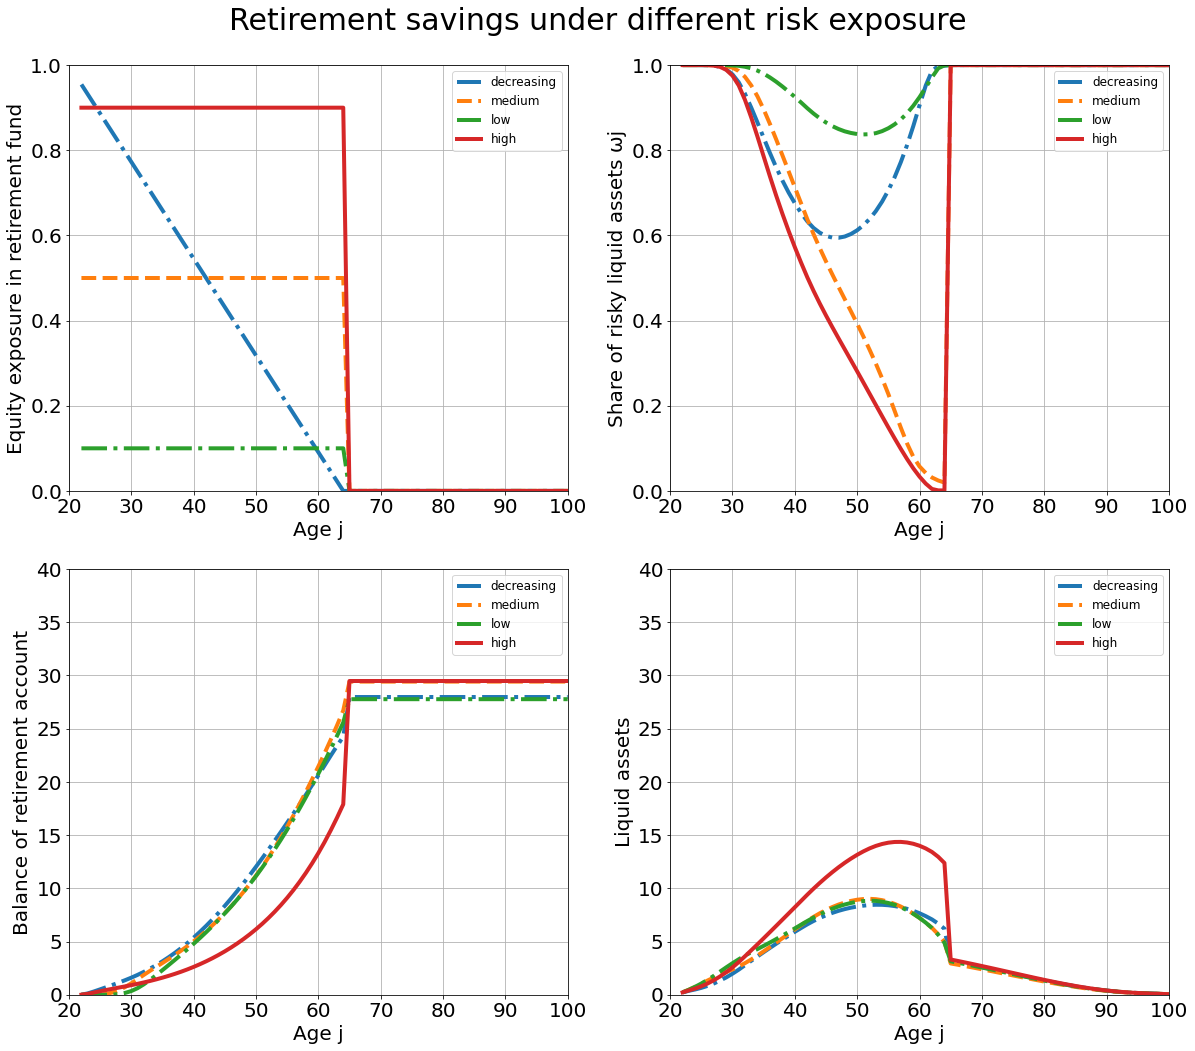

In [58]:
plt.rcParams['lines.linewidth'] = '4'
plt.rcParams.update({'font.size': 20})
ages = np.arange(model1.J) + 21

fig, ax = plt.subplots(2,2,figsize = (17,15))
fig.suptitle('Retirement savings under different risk exposure', fontsize = 30)

model = [model1, model2, model3, model4]
lab = ['decreasing','medium', 'low', 'high']
linstyle = ['-.','--', '-.', '-', ':']

for i in range(4):
    ax[0,0].plot(ages[1:], model[i].ωj[1:], label = lab[i], linestyle = linstyle[i])
ax[0,0].set_ylabel('Equity exposure in retirement fund')

for i in range(4):
    ax[0,1].plot(ages[1:], model[i].o_coh[1:], label = lab[i], linestyle = linstyle[i])
ax[0,1].set_ylabel('Share of risky liquid assets ωj')

for i in range(4):
    ax[1,0].plot(ages[1:], model[i].ar_coh[1:], label = lab[i], linestyle = linstyle[i])
ax[1,0].set_ylabel('Balance of retirement account')

for i in range(4):
    ax[1,1].plot(ages[1:], model[i].a_coh[1:], label = lab[i], linestyle = linstyle[i])
ax[1,1].set_ylabel('Liquid assets')
    
for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize = 12)
        if i == 0:
            ax[i,j].set_ylim(0,1)
        else:
            ax[i,j].set_ylim(0,40)
        ax[i,j].set_xlim(20,100)
        ax[i,j].set_xlabel('Age j')
        ax[i,j].grid()
fig.tight_layout() 